In [54]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import itertools as it

file_name = 'test_z_mask_02.pam'
data_dir = 'data'

file_path = os.path.join(data_dir, file_name)

In [55]:
def bytes_to_int_arr(byts):
    return [b for b in byts]


def pop_byte(byte_arr):
    return byte_arr.pop(0)


def pop_bytes(byte_arr, length):
    return bytes([pop_byte(byte_arr) for _ in range(length)])


def pop_uint8(byte_arr):
    return pop_byte(byte_arr)


def pop_uint32(byte_arr, byteorder='little'):
    byts = pop_bytes(byte_arr, 4)
    return int.from_bytes(byts, byteorder)
    
    
def pop_string(byte_arr, length, encoding='utf-8'):
    byts = pop_bytes(byte_arr, length)
    return byts.decode(encoding)
    
        
def indent(string):
    indent_str = ' ' * 3
    return indent_str + (('\n' + indent_str).join(string.splitlines()))

In [56]:
class PhotoactivationMaskSlice:
    
    def __init__(self, header=None, footer=None, data=None):
        self.header = header
        self.data = data if data is None else bytes(data)
        self.footer = footer if footer is None else bytes(footer)

    def __repr__(self):
        repr_str = '''{:s}(
   header={},
   footer={},
   data={})'''.format(
            self.__class__.__name__,
            self.header,
            bytes_to_int_arr(self.footer),
            bytes_to_int_arr(self.data))
        return repr_str

        
class PhotoactivationMask:
    
    def __init__(self, name=None, shape=None, slices=None,):
        self.shape = shape
        self.slices = list() if slices is None else slices
        self.name = str() if name is None else name

    def __repr__(self):
        repr_str = '''{:s}(
   name=\'{:s}\',
   shape={},
   slices=[{:s}])'''.format(
            self.__class__.__name__,
            self.name, 
            self.shape, 
            '' if not self.slices else ('\n' + 
            indent(',\n'.join(indent(repr(sl)) for sl in self.slices))))
        return repr_str
        
    @staticmethod
    def build_from_binary(byts):
        byts = bytearray(byts)
        pam = PhotoactivationMask()
        
        name_length = pop_uint8(byts)
        pam.name = pop_string(byts, name_length)
        print(pam.name)
        
        pam.shape = tuple(pop_uint32(byts) for _ in range(3))
        print(pam.shape)
        
        slice_footer_length = 32        
        while byts:            
            pam_slice = PhotoactivationMaskSlice()
            slice_data_length = pop_uint32(byts)
            pam_slice.header = (slice_data_length, pop_uint32(byts))
            print(pam_slice.header)
            pam_slice.data = pop_bytes(byts, slice_data_length)
            pam_slice.footer = pop_bytes(byts, slice_footer_length)
            print(pam_slice)
            pam.slices.append(pam_slice)
        
        assert len(pam.slices) == pam.shape[2]
        
        return pam
    
    @staticmethod
    def build_from_file(path):
        with open(path, 'rb') as fle:
            byts = fle.read()
        return PhotoactivationMask.build_from_binary(byts)

In [57]:
pam = PhotoactivationMask.build_from_file(file_path)
print(pam)

128x128_test_mask_02
(128, 128, 5)
(20, 12)
PhotoactivationMaskSlice(
   header=(20, 12),
   footer=[7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   data=[14, 129, 0, 108, 1, 16, 192, 219, 0, 0, 0, 0, 2, 0, 0, 16, 0, 0, 0, 0])
(29788, 29780)
PhotoactivationMaskSlice(
   header=(29788, 29780),
   footer=[116, 115, 0, 0, 108, 115, 0, 0, 218, 195, 149, 239, 1, 16, 192, 219, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 16],
   data=[37, 220, 225, 168, 1, 16, 192, 219, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 16, 108, 1, 0, 0, 1, 16, 192, 219, 39, 0, 0, 0, 0, 32, 0, 0, 133, 235, 49, 64, 0, 0, 128, 63, 133, 235, 49, 64, 127, 124, 218, 63, 63, 62, 13, 64, 133, 235, 17, 64, 0, 0, 192, 63, 133, 235, 17, 64, 0, 7, 75, 63, 133, 235, 17, 64, 176, 71, 97, 62, 127, 124, 218, 63, 176, 71, 97, 62, 0, 0, 128, 63, 176, 71, 97, 62, 0, 14, 150, 62, 0, 7, 75, 63, 40, 92, 143, 190, 0, 0, 192, 63, 40, 92, 143, 190, 63, 62, 13, 64, 40, 92, 143, 190, 133,

IndexError: pop from empty bytearray

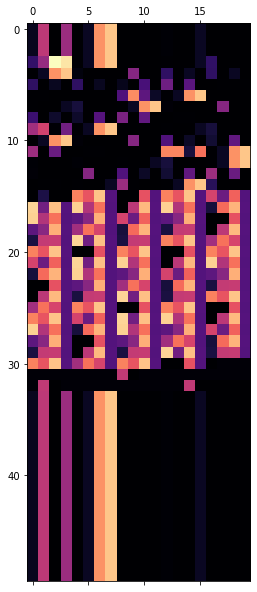

In [24]:
all_mask_data = bytes_to_int_arr(bytes().join(sl.data for sl in pam.slices))
mask_data_np = np.array(all_mask_data)
original_size = mask_data_np.size

vis_width = 20
new_shape = (np.ceil(mask_data_np.size / vis_width).astype(int), vis_width)
mask_data_vis = np.resize(mask_data_np.astype(float), new_shape)

num_extra_values = mask_data_vis.size - original_size
extra_value_idxs = mask_data_vis.size - (np.arange(num_extra_values) + 1)
extra_value_slice = np.unravel_index(extra_value_idxs, mask_data_vis.shape)
mask_data_vis[extra_value_slice] = np.NaN

plt.matshow(mask_data_vis, cmap='magma')